In [1]:
import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tqdm.notebook import tqdm

import gala.coordinates as gc
from astroquery.gaia import Gaia
from astroquery.mast import Catalogs
from astroquery.utils.tap.core import Tap

Created TAP+ (v20200428.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v20200428.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [2]:
center = coord.SkyCoord(0, 0, unit='deg', frame=gc.GD1Koposov10).icrs
radius = 1 * u.deg
center

<SkyCoord (ICRS): (ra, dec) in deg
    (200., 59.4504341)>

### Gaia

In [3]:
Gaia.ROW_LIMIT = 1000000
job = Gaia.cone_search_async(center, radius=radius, 
                             table_name='gaiaedr3.gaia_source')
gaia_data = job.get_results()
gaia_data = gaia_data[
    (~gaia_data['parallax'].mask) &
    (~gaia_data['pmra'].mask) &
    (~gaia_data['pmdec'].mask)
]

INFO: Query finished. [astroquery.utils.tap.core]


### Legacy Surveys

Query entered at: https://datalab.noirlab.edu/query.php?name=ls_dr9.tractor

In [4]:
q = f'''
SELECT * FROM ls_dr9.tractor AS t
WHERE Q3C_RADIAL_QUERY(ra, dec, {center.ra.degree:.5f}, {center.dec.degree:.5f}, {radius.to_value(u.degree):.5f})
'''
print(q)


SELECT * FROM ls_dr9.tractor AS t
WHERE Q3C_RADIAL_QUERY(ra, dec, 200.00000, 59.45043, 1.00000)



In [5]:
decals_data = at.Table.read('../data/ls_dr9_test_field.txt', 
                            format='ascii.basic')

In [6]:
decals_stars = decals_data[decals_data['type'] == 'PSF']
len(decals_stars)

65909

### Pan-STARRS

In [30]:
ps1_data_raw = Catalogs.query_criteria(
    coordinates=center,
    radius=radius,                                   
    catalog="PANSTARRS", table="mean", data_release="dr2",
    nr=[("gte", 1)],
    ni=[("gte", 1)],
    columns=["objName", "objID",
             "raMean", "decMean", 
             "gMeanPSFMag", "rMeanPSFMag", "zMeanPSFMag", "iMeanPSFMag", 
             "iMeanKronMag",
             "gMeanPSFMagErr", "rMeanPSFMagErr", "iMeanPSFMagErr", "zMeanPSFMagErr",
             "ng", "nr", "ni", "ndetections"],
    # sort_by=[("desc", "distance")], 
    pagesize=100_000
)

ps1_data = ps1_data_raw.copy()
# ps1_data = ps1_data[~ps1_data['gMeanPSFMag'].mask]

# Hacky Star-Galaxy separation, see 
# https://outerspace.stsci.edu/display/PANSTARRS/How+to+separate+stars+and+galaxies
sg_mask = (ps1_data['iMeanPSFMag'] - ps1_data['iMeanKronMag']) < 0.06
# ps1_data = ps1_data[sg_mask]

In [31]:
len(ps1_data), len(gaia_data), len(decals_stars)

(43715, 8015, 65909)

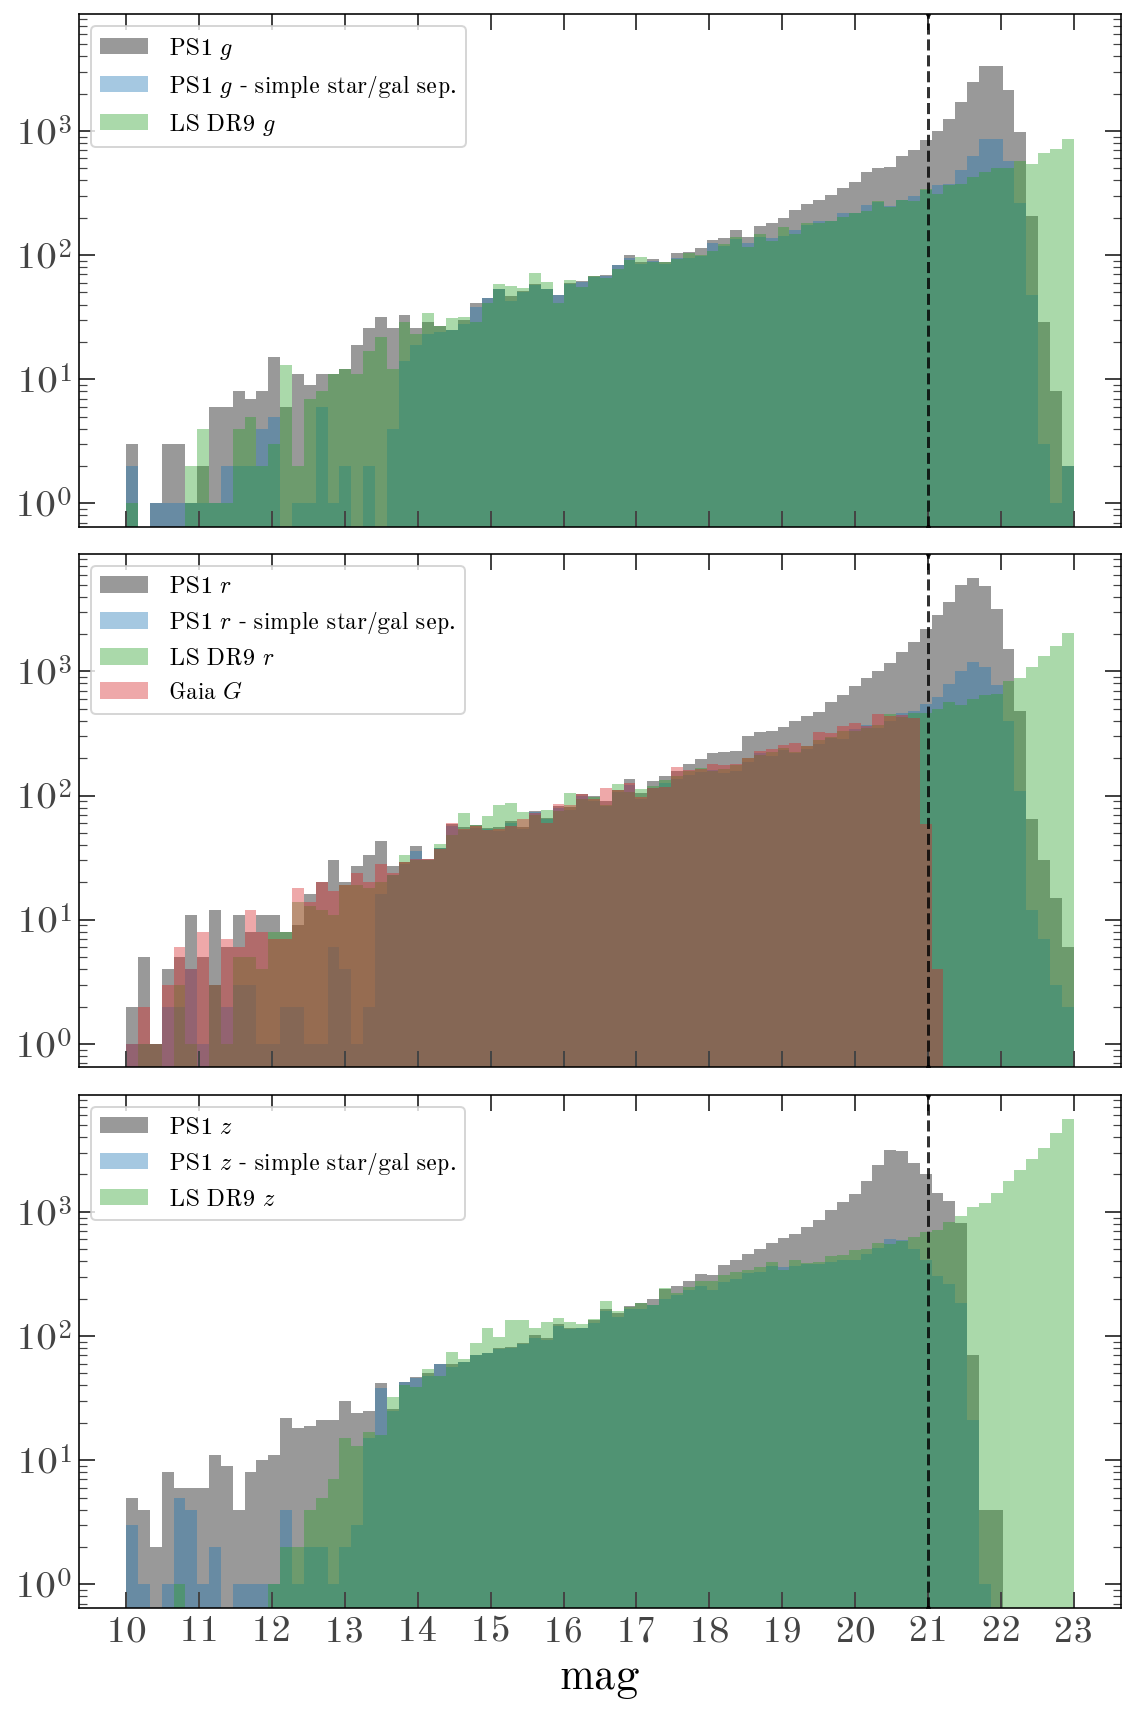

In [39]:
bins = np.linspace(10, 23, 81)

mag_names = ['g', 'r', 'z']

fig, axes = plt.subplots(len(mag_names), 1, figsize=(8, 4 * len(mag_names)),
                         sharex=True, sharey=True)

for i, m in enumerate(mag_names):
    ax = axes[i]

    ax.hist(ps1_data[f'{m}MeanPSFMag'], bins=bins, alpha=0.4, 
            label=f'PS1 ${m}$')
    ax.hist(ps1_data[f'{m}MeanPSFMag'][sg_mask], bins=bins, alpha=0.4, 
            label=f'PS1 ${m}$ - simple star/gal sep.', color='tab:blue')

    ax.hist(decals_stars[f'mag_{m}'], bins=bins, alpha=0.4, color='tab:green',
            label=f'LS DR9 ${m}$')
    
    if m == 'r':
        ax.hist(gaia_data['phot_g_mean_mag'], bins=bins, alpha=0.4, 
                label='Gaia $G$', color='tab:red')
    
    ax.legend(fontsize=12)
    
    ax.axvline(21, color='k', linestyle='--', alpha=0.8)

ax.set_xticks(np.arange(10, 23+1, 1))
ax.set_yscale('log')
ax.set_xlabel('mag')

fig.tight_layout()

In [ ]:
a


In [12]:
ps1_c = coord.SkyCoord(
    ps1_data['raMean'], ps1_data['decMean'],
    unit=u.deg
)

gaia_c = coord.SkyCoord(
    gaia_data['ra'], gaia_data['dec']
)

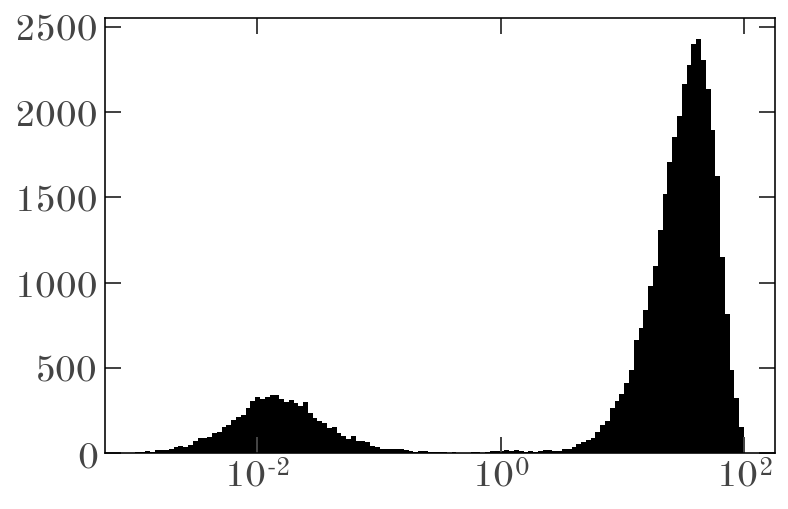

In [13]:
idx, sep, _ = ps1_c.match_to_catalog_sky(gaia_c)

plt.hist(sep.arcsec, bins=np.logspace(-3, 2, 128));
plt.xscale('log')

sep_mask = sep < 2*u.arcsec
ps1_x_gaia = at.hstack((ps1_data[sep_mask], gaia_data[idx[sep_mask]]))

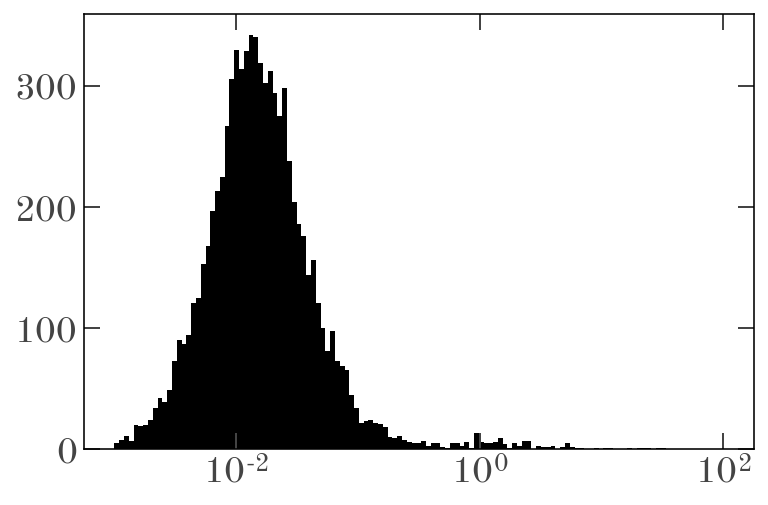

In [14]:
idx, sep, _ = gaia_c.match_to_catalog_sky(ps1_c)

plt.hist(sep.arcsec, bins=np.logspace(-3, 2, 128));
plt.xscale('log')

sep_mask = sep < 2*u.arcsec
gaia_x_ps1 = at.hstack((gaia_data[sep_mask], ps1_data[idx[sep_mask]]))

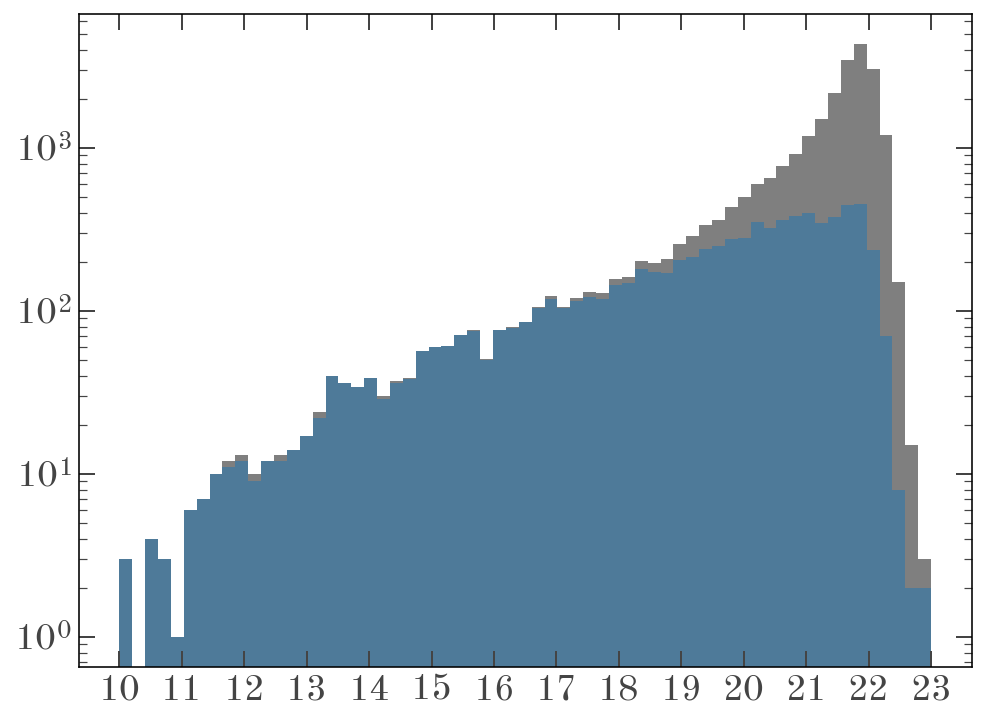

In [15]:
g_bins = np.linspace(10, 23, 64)

plt.figure(figsize=(8, 6))
plt.hist(ps1_data['gMeanPSFMag'], bins=g_bins, alpha=0.5);
plt.hist(ps1_x_gaia['gMeanPSFMag'], bins=g_bins, alpha=0.5);
plt.xticks(np.arange(10, 23+1, 1))
plt.yscale('log')

### Sources in Gaia but not PS1:

In [16]:
missing_mask = (
    ~np.isin(gaia_data['source_id'], gaia_x_ps1['source_id']) &
    (gaia_data['phot_g_mean_mag'] > 14.5)
)
missing = gaia_data[missing_mask]
missing = missing[missing['phot_g_mean_mag'].argsort()]
len(missing)

45

In [17]:
len(gaia_data), len(ps1_data), len(missing)

(8015, 43715, 45)

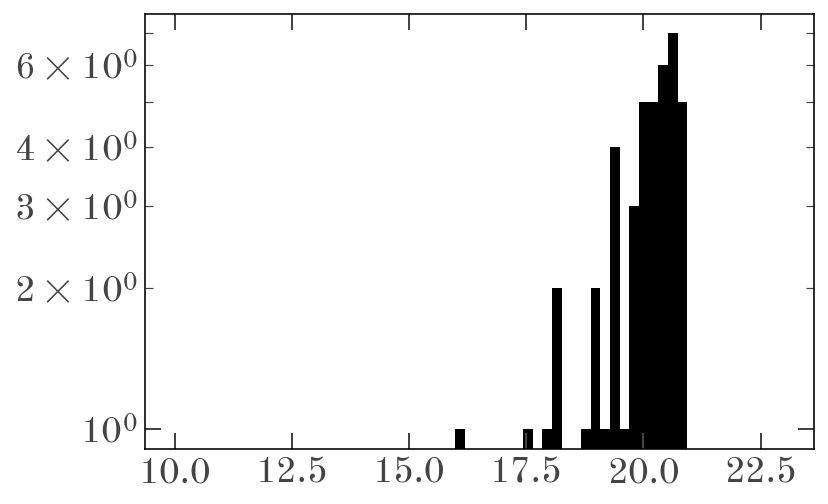

In [18]:
plt.hist(missing['phot_g_mean_mag'], bins=g_bins);
plt.yscale('log')

In [248]:
missing['source_id', 'ra', 'dec', 'phot_g_mean_mag']

source_id,ra,dec,phot_g_mean_mag
,deg,deg,mag
int64,float64,float64,float32
1566825033316989056,199.50292495774085,58.70077158383173,16.062376
1663058173629844096,200.16197508354486,59.94768424393696,17.560165
1566903506665004032,200.11314774201958,58.695692510982525,17.932735
1567222472410642048,198.463755352419,59.84563445544125,18.069204
1566900315503597440,200.6868373336294,59.22366709886005,18.072157
1567155024243754752,199.23409281915792,59.584617075609835,18.784801
1663247491495303680,199.92017154386315,60.05239046931464,18.906097
1567038098053890176,198.49290728277305,59.116836434440394,19.027554


### Completeness of Gaia x PS1 sample:

Text(0.5, 0, '$g$ mag')

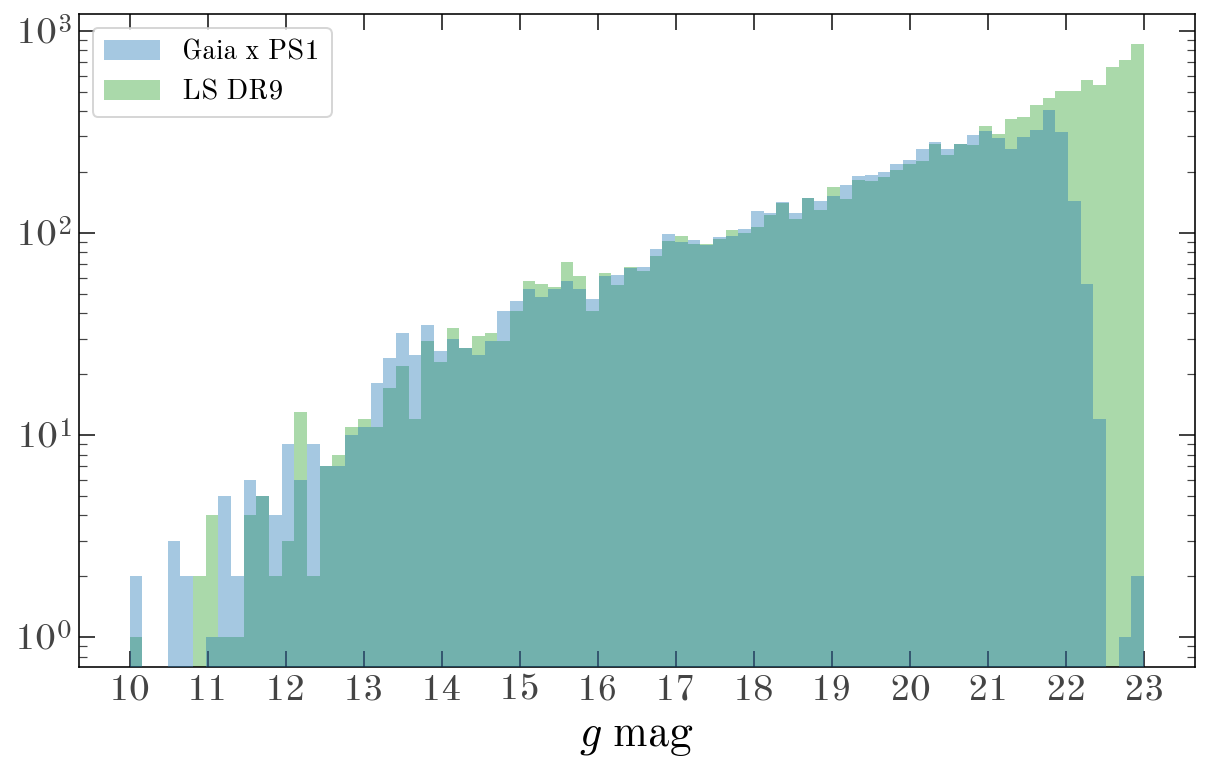

In [20]:
g_bins = np.linspace(10, 23, 81)

plt.figure(figsize=(10, 6))
plt.hist(gaia_x_ps1['gMeanPSFMag'][~gaia_x_ps1['parallax'].mask], bins=g_bins, alpha=0.4, 
         label='Gaia x PS1', color='tab:blue', zorder=10)

plt.hist(decals_stars['mag_g'], bins=g_bins, alpha=0.4, color='tab:green',
         label='LS DR9')

plt.xticks(np.arange(10, 23+1, 1))
plt.yscale('log')
plt.legend(fontsize=14)
plt.xlabel('$g$ mag')

Text(0.5, 0, 'mag')

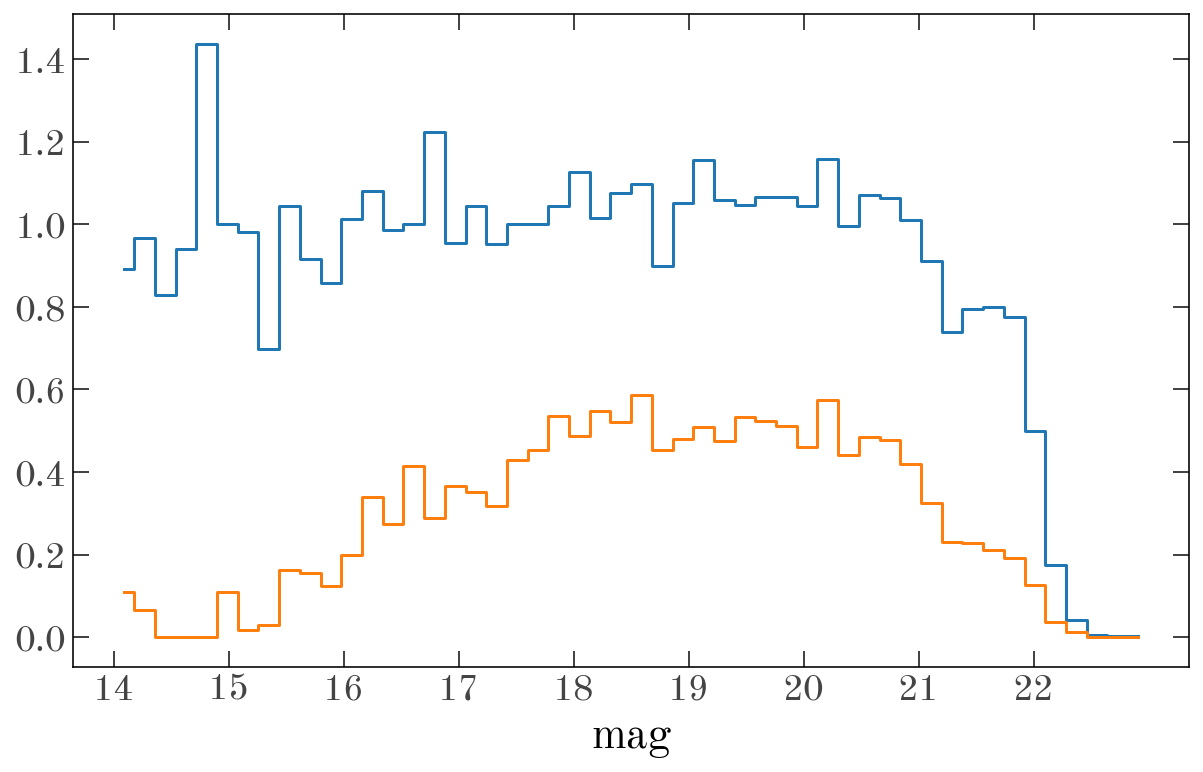

In [28]:
_bins = np.linspace(14., 23, 51)

plt.figure(figsize=(10, 6))

H_gaia, _ = np.histogram(
    gaia_x_ps1['gMeanPSFMag'], 
    bins=_bins
)

H_gaia_plx, _ = np.histogram(
    gaia_x_ps1['gMeanPSFMag'][gaia_x_ps1['parallax'] < 0.5], 
    bins=_bins
)

H_ls, _ = np.histogram(
    decals_stars['mag_g'],
    bins=_bins
)

plt.plot(
    0.5 * (_bins[:-1] + _bins[1:]), 
    H_gaia / H_ls,
    drawstyle='steps-mid',
    marker='',
    color='tab:blue'
)

plt.plot(
    0.5 * (_bins[:-1] + _bins[1:]), 
    H_gaia_plx / H_ls,
    drawstyle='steps-mid',
    marker='',
    color='tab:orange'
)

plt.xticks(np.arange(_bins.min(), _bins.max(), 1))
plt.xlabel('mag')